# Data pre-processing
 
**Autori:** Erik Matovič a Simon Kokavec   
**Číslo datasetu:** 165  
**Percentuálny podiel:** 50/50

## 0. Importovanie

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as py
import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
import math
from datetime import datetime, date

## 1. Integrácia a čistenie dát

### Zadanie  
Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte. 
- Pri riešení chýbajúcich hodnôt (missing values) vyskúšajte rôzne stratégie z nasledujúcich podskupín:
    - odstránenie pozorovaní s chýbajúcimi údajmi
    - nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN
- Podobne postupujte aj pri riešení vychýlených hodnôt (outlier detection):
    - odstránenie vychýlených (odľahlých) pozorovaní
    - nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)
    
### Riešenie


In [2]:
# read labor and profiles dataset
df_labor = pd.read_csv('../../data/labor.csv', sep='\t')
df_profiles = pd.read_csv('../../data/profiles.csv', sep='\t')

# TODO:
### Spojiť datasety 
### Doriešiť chýbajúce hodnoty

#### Dataset profilov
**Atribút unnamed(0)** 
- Celý stĺpec vymazať

In [3]:
df_profiles=df_profiles.drop("Unnamed: 0", axis=1)
df_profiles.head()

,name,sex,current_location,blood_group,residence,birthdate,race,ssn,address
0,Elizabeth Johnson,F,"(Decimal('-64.545933'), Decimal('5.817377'))",B-,"319 Bradley Tunnel Suite 246\nBoyerstad, GA 12067","10/30/1938, 00:00:00",White,518-82-6493,"09441 Joyce Route Suite 717\nWest Megan, GA 12969"
1,Scott Holmes,M,"(Decimal('-18.8183775'), Decimal('94.375497'))",A-,"28739 Hoffman Valleys Apt. 636\nMichaelville, ...",1927-06-20,Black,015-03-8632,USNS Miller\nFPO AE 08377
2,William Roth,M,"(Decimal('35.903361'), Decimal('-133.029344'))",B-,"8623 Jordan Canyon Suite 498\nJoshuastad, OH 3...",1965-10-02,Black,898-78-8500,"7747 Nicole Wells\nShannonside, MI 84296"
3,Kimberly Barnes,F,"(Decimal('55.2055095'), Decimal('-121.665483'))",B+,Unit 0522 Box 6156\nDPO AE 24368,1962-02-14,White,478-72-0155,"228 Colleen Extension\nLake Morgan, AL 34806"
4,Sarah Escobar,F,"(Decimal('49.512264'), Decimal('-121.259776'))",AB-,"30306 Molina Junction\nPort Edwardview, OK 72746",02 Oct 1936,Indian,683-31-6335,"08249 Gentry Fall\nLewisshire, NY 20037"


**Atribút name** 
- tento stĺpec je celý v poriadku

In [4]:
df_profiles["name"].head()

0    Elizabeth Johnson
1         Scott Holmes
2         William Roth
3      Kimberly Barnes
4        Sarah Escobar
Name: name, dtype: object

**Atribút sex** 
- tento stĺpec treba pretransformovať na numerický 
    - *1 - žena, 0 - muž*

In [5]:
df_profiles["sex"].replace({"M": 0, "F": 1}, inplace=True)

In [6]:
df_profiles = df_profiles.astype({'sex': 'category'})

In [7]:
df_profiles["sex"].value_counts()

0    1557
1    1507
Name: sex, dtype: int64

In [8]:
df_profiles["sex"].head()

0    1
1    0
2    0
3    1
4    1
Name: sex, dtype: category
Categories (2, int64): [0, 1]

Tento stĺpec sme úspešne transformovali na dátový typ category a nahradili sme jeho východiskové hodnoty M a F za False a True.

**Atribbút current_location** 
- Tento stĺpec je celý v poriadku


In [9]:
df_profiles["current_location"].head()

0       (Decimal('-64.545933'), Decimal('5.817377'))
1     (Decimal('-18.8183775'), Decimal('94.375497'))
2     (Decimal('35.903361'), Decimal('-133.029344'))
3    (Decimal('55.2055095'), Decimal('-121.665483'))
4     (Decimal('49.512264'), Decimal('-121.259776'))
Name: current_location, dtype: object

**Atribút blood_group** 
- Kategorizovať hodnoty nasledovne: 
    - **1 - A+, 2 - A-, 3 - B+, 4 - B-, 5 - AB+, 6 - AB-, 7 - O+, 8 - O-**

In [10]:
df_profiles['blood_group'] = df_profiles['blood_group'].replace({"A+": 1,"A-": 2, "B+": 3, "B-": 4, "AB+": 5, "AB-": 6, "O+": 7, "O-": 8})
df_profiles = df_profiles.astype({'blood_group': 'category'})
df_profiles.blood_group.value_counts()

1    398
3    395
8    394
7    389
5    388
2    377
6    364
4    359
Name: blood_group, dtype: int64

In [11]:
df_profiles["blood_group"].head()

0    4
1    2
2    4
3    3
4    6
Name: blood_group, dtype: category
Categories (8, int64): [1, 2, 3, 4, 5, 6, 7, 8]

**Atribút residence** 
- Tento stĺpec je celý v poriadku

In [12]:
df_profiles["residence"].head()

0    319 Bradley Tunnel Suite 246\nBoyerstad, GA 12067
1    28739 Hoffman Valleys Apt. 636\nMichaelville, ...
2    8623 Jordan Canyon Suite 498\nJoshuastad, OH 3...
3                     Unit 0522 Box 6156\nDPO AE 24368
4     30306 Molina Junction\nPort Edwardview, OK 72746
Name: residence, dtype: object

**Atribút birthdate** 
- Neobsahuje žiadne chýbajúce hodnoty
- Pretransformovať na jednotný tvar
- Vypočítať vek pacienta

In [13]:
df_profiles['birthdate'] = df_profiles['birthdate'].astype('datetime64[ns]')
df_profiles['birthdate'].head()

0   1938-10-30
1   1927-06-20
2   1965-10-02
3   1962-02-14
4   1936-10-02
Name: birthdate, dtype: datetime64[ns]

In [14]:
df_profiles['birthdate'].isna().value_counts()

False    3064
Name: birthdate, dtype: int64

In [15]:
def age(born):
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))
  
df_profiles['age'] = df_profiles['birthdate'].apply(age)
  
df_profiles['age'].head()

0    83
1    94
2    56
3    59
4    85
Name: age, dtype: int64

**Atribút race** 
- Neobsahuje žiadne chýbajúce hodnoty
- Kategorizovať hodnoty nasledovne: 
    - **1 - White, 2 - Black, 3 - Asian, 4 - Hawaiian, 5 - Indian**

In [16]:
df_profiles.race.value_counts()

White       1565
Black        722
Asian        281
Hawaiian     170
Indian       159
black        102
white         36
blsck         29
Name: race, dtype: int64

Najskôr musíme upraviť hodnoty kde je chyba a ktoré majú na začiatku malé písmeno namiesto veľkého.

In [17]:
df_profiles['race'] = df_profiles['race'].replace({"blsck": "Black", "black": "Black", "white": "White"})

In [18]:
df_profiles.race.value_counts()

White       1601
Black        853
Asian        281
Hawaiian     170
Indian       159
Name: race, dtype: int64

Následne tieto hodnoty kategorizujeme ako sme uviedli vyššie.

In [19]:
df_profiles['race'] = df_profiles['race'].replace({"White": 1,"Black": 2, "Asian": 3, "Hawaiian": 4, "Indian": 5})
df_profiles = df_profiles.astype({'race': 'category'})
df_profiles.race.value_counts()

1    1601
2     853
3     281
4     170
5     159
Name: race, dtype: int64

In [20]:
df_profiles["race"].head()

0    1
1    2
2    2
3    1
4    5
Name: race, dtype: category
Categories (5, int64): [1, 2, 3, 4, 5]

**Atribút ssn** 
- Tento stĺpec je celý v poriadku

**Atribút address** 
- Tento stĺpec je celý v poriadku

#### Dataset laboratórnych výsledkov
**Atribút unnamed(0)** 
- Celý stĺpec vymazať

In [21]:
df_labor=df_labor.drop("Unnamed: 0", axis=1)
df_labor.head()

,hemoglobin,leukocyty,etytr,weight,trombocyty,ast,alp,relationship,name,alt,hbver,smoker,erytrocyty,er-cv,indicator,ssn,hematokrit
0,6.77299,5.28153,4.79087,104.22450,7.22472,61.85014,80.77401,married,Kathryn Wagner,2.01576,9.04461,no,7.94417,61.31451,0.0,887-91-9698,5.40103
1,6.35217,5.45245,3.34754,65.03608,7.00407,66.90722,90.01585,widowed,Frank Becker,0.81519,9.09262,no,5.33302,58.00624,0.0,506-37-0250,7.68167
2,5.37162,7.36106,7.10989,63.61518,6.95232,65.33091,74.23784,married,Stephanie Lewis,0.79787,6.18215,no,6.38771,62.73102,1.0,331-52-1241,6.27422
3,4.60987,8.04010,4.97779,30.35294,6.63243,67.33708,34.67995,married,Luis Williams,0.83917,5.22920,no,5.05640,62.60592,1.0,407-22-7513,6.61263
4,5.97408,6.66899,5.58872,97.97181,6.18242,67.48751,89.31030,divoced,Donald Hall,1.20122,4.97805,yes,5.10205,59.32470,1.0,486-30-7935,6.23117


**Atribút hemoglobin** 
- Obsahuje chýbajúce hodnoty

In [22]:
hemoglobin_mean = df_labor["hemoglobin"].mean()
df_labor["hemoglobin"].loc[df_labor["hemoglobin"].isna(),].fillna(hemoglobin_mean)

320     6.416198
627     6.416198
835     6.416198
905     6.416198
1505    6.416198
1804    6.416198
1861    6.416198
1913    6.416198
1950    6.416198
2502    6.416198
3562    6.416198
3657    6.416198
3784    6.416198
4190    6.416198
4813    6.416198
4963    6.416198
5462    6.416198
5491    6.416198
5791    6.416198
6038    6.416198
6288    6.416198
7217    6.416198
7558    6.416198
8075    6.416198
8257    6.416198
8346    6.416198
8971    6.416198
9335    6.416198
9430    6.416198
9873    6.416198
Name: hemoglobin, dtype: float64

In [23]:
df_labor["hemoglobin"].loc[df_labor["hemoglobin"].isna(),].count()

0

**Atribút leukocyty** 
- Obsahuje chýbajúce hodnoty

In [24]:
leukocyty_mean = df_labor["leukocyty"].mean()
df_labor["leukocyty"].loc[df_labor["leukocyty"].isna(),].fillna(leukocyty_mean)

187      6.777737
390      6.777737
398      6.777737
563      6.777737
588      6.777737
640      6.777737
923      6.777737
1577     6.777737
1950     6.777737
2467     6.777737
2809     6.777737
2817     6.777737
3368     6.777737
3618     6.777737
3677     6.777737
4473     6.777737
4658     6.777737
4882     6.777737
4919     6.777737
5743     6.777737
7035     6.777737
7083     6.777737
7218     6.777737
7324     6.777737
7555     6.777737
8500     6.777737
9219     6.777737
9593     6.777737
9691     6.777737
9869     6.777737
10021    6.777737
Name: leukocyty, dtype: float64

In [25]:
df_labor["leukocyty"].loc[df_labor["leukocyty"].isna(),].count()

0

**Atribút etytr** 
- Obsahuje chýbajúce hodnoty

**Atribút weight** 
- Neobsahuje žiadne chýbajúce hodnoty
- Obsahuje mínusové hodnoty

In [26]:
weight_median=df_labor["weight"].median()
df_labor.loc[df_labor["weight"] < 0] = weight_median

In [27]:
df_labor["weight"].loc[df_labor["weight"] < 0].count()

0

**Atribút trombocyty** 
- Obsahuje chýbajúce hodnoty

**Atribút ast** 
- Obsahuje chýbajúce hodnoty

**Atribút alp** 
- Obsahuje chýbajúce hodnoty

**Atribút relationship** 
- Neobsahuje žiadne chýbajúce hodnoty
- Kategorizovať hodnoty nasledovane:
    - **1 - Married, 2 - Divorced, 3 - Single, 4 - Separated, 5 - nop, 6 - widowed**

In [28]:
df_labor.relationship.value_counts()

divoced      2445
married      2439
single       1973
separated    1053
nop           981
widowed       941
69.49181      203
Name: relationship, dtype: int64

In [29]:
df_labor['relationship'] = df_labor['relationship'].replace({"married": 1, "divoced": 2, "single": 3, "separated": 4, "nop": 5,"widowed": 6})
df_labor = df_labor.astype({'relationship': 'category'})
df_labor.relationship.value_counts()

2.0         2445
1.0         2439
3.0         1973
4.0         1053
5.0          981
6.0          941
69.49181     203
Name: relationship, dtype: int64

In [30]:
df_labor["relationship"].head()

/home/erik/.local/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


0    1.0
1    6.0
2    1.0
3    1.0
4    2.0
Name: relationship, dtype: category
Categories (7, float64): [1.00000, 2.00000, 3.00000, 4.00000, 5.00000, 6.00000, 69.49181]

**Atribút name** 
- Neobsahuje žiadne chýbajúce hodnoty

**Atribút alt** 
- Obsahuje chýbajúce hodnoty

**Atribút hbver** 
- Obsahuje chýbajúce hodnoty

**Atribút smoker** 
- Neobsahuje žiadne chýbajúce hodnoty
- Kategorizovať hodnoty nasledovane:
    - **1 (True) - Yes, 0 (False) - No**

In [31]:
df_labor.smoker.value_counts()

no          5320
Y           2046
yes         1927
N            539
69.49181     203
Name: smoker, dtype: int64

In [32]:
df_labor['smoker'] = df_labor['smoker'].replace({"no": 0, "N": 0, "yes": 1, "Y": 1})
df_labor = df_labor.astype({'smoker': 'category'})
df_labor.smoker.value_counts()

0.0         5859
1.0         3973
69.49181     203
Name: smoker, dtype: int64

In [33]:
df_labor["smoker"].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: smoker, dtype: category
Categories (3, float64): [0.00000, 1.00000, 69.49181]

**Atribút erytrocyty** 
- Obsahuje chýbajúce hodnoty

**Atribút er-cv** 
- Obsahuje chýbajúce hodnoty

**Atribút indicator** 
- Neobsahuje žiadne chýbajúce hodnoty
- Zmeniť dátový typ stĺpcu

In [34]:
df_labor = df_labor.astype({'indicator': 'category'})
df_labor.indicator.value_counts()

1.0         6304
0.0         3528
69.49181     203
Name: indicator, dtype: int64

In [35]:
df_labor["indicator"].head()

0    0.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: indicator, dtype: category
Categories (3, float64): [0.00000, 1.00000, 69.49181]

**Atribút ssn** 
- Neobsahuje žiadne chýbajúce hodnoty

**Atribút hematokrit** 
- Obsahuje chýbajúce hodnoty

#### Deduplikácia

In [36]:
df_labor.duplicated(keep=False).value_counts()

False    9636
True      399
dtype: int64

In [37]:
df_labor=df_labor.drop_duplicates()

In [38]:
df_labor.duplicated(keep=False).value_counts()

False    9735
dtype: int64

#### Outliers

In [39]:
def outlier_ninja(column):
    global df_labor
    df_labor.loc[df_labor[column] < df_labor[column].quantile(.05), column] = df_labor[column].quantile(.05)
    df_labor.loc[df_labor[column] > df_labor[column].quantile(.95) , column] = df_labor[column].quantile(.95) 

def release_outlier_ninja():
    global df_labor
    outlier_ninja('leukocyty')
    outlier_ninja('hemoglobin')
    outlier_ninja('erytrocyty')


def outlier_ninja2(column):
    global df_labor
    if ((stats.skew(df_labor[column]) < -2) or (stats.skew(df_labor[column]) > 2)):
        df_labor[column] = np.log(df_labor[column]+ (-df_labor[column].min()))
    df_labor.loc[df_labor[column] < df_labor[column].quantile(.05), column] = df_labor[column].quantile(.05)
    df_labor.loc[df_labor[column] > df_labor[column].quantile(.95) , column] = df_labor[column].quantile(.95) 

def release_outlier_ninja2():
    global df_labor
    outlier_ninja2('leukocyty')
    outlier_ninja2('hemoglobin')
    outlier_ninja2('erytrocyty')



In [40]:
release_outlier_ninja()

<AxesSubplot:>

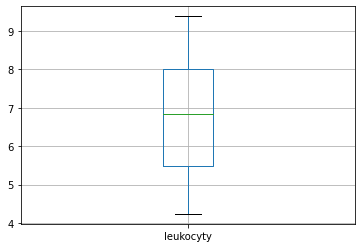

In [41]:
df_labor.boxplot(column=['leukocyty'])

In [42]:
release_outlier_ninja2()

<AxesSubplot:>

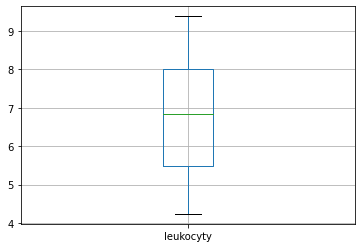

In [43]:
df_labor.boxplot(column=['leukocyty'])

## 2. Realizácia predspracovania dát 

### Zadanie  
- Transformované dáta pre strojové učenie si rozdeľuje na trénovaciu a testovaciu množinu (train and test dataset) podľa vami preddefinovaným pomerom. Naďalej pracujte len s trénovacím datasetom.
- Transformujte atribútov dát pre strojové učenie podľa dostupných techník (minimálne 2 techniky) ako scaling, transformers a ďalšie.
- Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)
    
### Riešenie



## 3. Výber atribútov pre strojové učenie

### Zadanie  
- Zistite ktoré atribúty (features) vo vašich dátach pre strojové učenie sú informatívne k atribútu “indikator”.
- Zoradíte tie atribúty v poradí podľa dôležitosti. 
- Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie) 

### Riešenie




## 4. Replikovateľnosť predspracovania

### Zadanie  
- Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť na predspracovanie testovacej množiny (napr. pomocou funkcie/í)
- Očakáva sa aj využitie možnosti sklearn.pipeline

### Riešenie



